In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib

import sklearn

#normalization
from sklearn import preprocessing

#oe hot encoder
from sklearn.preprocessing import OneHotEncoder

#train/test split
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

#metrics
from sklearn.metrics import accuracy_score

#baseline linear regression
from sklearn import linear_model
#baseline RF
from sklearn.ensemble import RandomForestClassifier

#dnn
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import DNN

#keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

%matplotlib inline

In [5]:
sys.version

'3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]'

In [2]:
df_train = pd.read_csv('train.csv')
print(df_train.shape)
df_train

y = df_train.label.values
print(y.shape)

df_train = df_train.drop(['label'], axis=1)
df_train /= 255
print(df_train.shape)

X = df_train.values

(42000, 785)
(42000,)
(42000, 784)


In [44]:
df_train['pixel0'] = df_train['pixel0'].astype(int)

In [45]:
type(df_train.iloc[0]['pixel0'])

numpy.float64

In [41]:
df_train.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

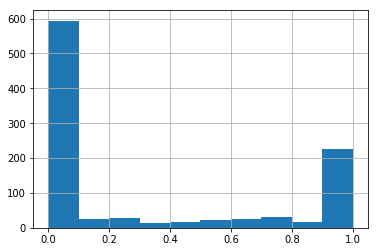

In [3]:
df_train.pixel300.hist()

In [15]:
df_train.pixel300.describe()

count    42000.000000
mean         0.279962
std          0.401214
min          0.000000
25%          0.000000
50%          0.000000
75%          0.647059
max          1.000000
Name: pixel300, dtype: float64

In [15]:
df_train.iloc[0].values

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [3]:
test_size = 0.05

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=test_size, random_state=0)

X_train_k = X_train
X_dev_k = X_dev

enc = OneHotEncoder()
Y_train_k = enc.fit_transform(y_train.reshape(-1, 1)).todense().A
Y_dev_k = enc.transform(y_dev.reshape(-1, 1)).todense().A
#Y_train_k = enc.fit_transform(y_train.reshape(-1, 1)).A
#Y_dev_k = enc.transform(y_dev.reshape(-1, 1)).A

X_train_my = X_train_k.T
X_dev_my = X_dev_k.T
Y_train_my = Y_train_k.T
Y_dev_my = Y_dev_k.T

print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)

(39900, 784)
(39900,)
(2100, 784)
(2100,)


In [16]:
#from scipy import sparse
#X_train_k = sparse.csr_matrix(X_train_k)
#X_dev_k = sparse.csr_matrix(X_dev_k)

In [4]:
#import gc
#del df_train
#gc.collect()

18

In [45]:
np.random.seed(0) # set a seed so that the results are consistent

clfs = []
clfs.append(sklearn.linear_model.LogisticRegression())
clfs.append(RandomForestClassifier(n_estimators=100, n_jobs=-1))

for clf in clfs:
    clf.fit(X_train, y_train);
    predictions = clf.predict(X_train)
    accuracy = accuracy_score(predictions, y_train)
    predictions = clf.predict(X_dev)
    accuracy2 = accuracy_score(predictions, y_dev)
    print(type(clf), accuracy, accuracy2)

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 1.0 0.963333333333


In [ ]:
<class 'sklearn.linear_model.logistic.LogisticRegression'> 0.930927318296 0.919523809524
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 1.0 0.963333333333

In [4]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, verbose):
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose != None and epoch % self.verbose == 0:
            print(epoch, logs['loss'], logs['acc'], logs['val_acc'])        

In [9]:
np.random.seed(0) # set a seed so that the results are consistent
#initializer = keras.initializers.RandomNormal(stddev=0.01)
initializer = keras.initializers.lecun_normal()
regularizer = None
#regularizer = regularizers.l2(0.01)
model = Sequential()
model.add(Dense(200, input_dim=X_train_k.shape[1], kernel_initializer=initializer, activation='tanh', kernel_regularizer=regularizer))
model.add(Dense(50, kernel_initializer=initializer, activation='tanh', kernel_regularizer=regularizer))
model.add(Dense(10, kernel_initializer=initializer, activation='softmax', kernel_regularizer=regularizer))
#optimizer = optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = optimizers.Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [11]:
np.random.seed(0) # set a seed so that the results are consistent
initial_epoch = 0
epochs = 100
#batch_size = int(X_train_k.shape[0])
batch_size = 256
verbose = 0
verbose2 = 100
results_k = model.fit(X_train_k, Y_train_k, batch_size=batch_size, epochs=epochs, callbacks=[MyCallback(verbose2)], validation_data = (X_dev_k, Y_dev_k), verbose=verbose, initial_epoch=initial_epoch)
Y_predict_k = model.predict(X_train_k)
print('Accuracy train', accuracy_score(Y_train_k.argmax(axis=1), Y_predict_k.argmax(axis=1)))
Y_predict_k = model.predict(X_dev_k)
print('Accuracy dev', accuracy_score(Y_dev_k.argmax(axis=1), Y_predict_k.argmax(axis=1)))

0 0.0863388996928 0.971954886656 0.962857143652
Accuracy train 0.985538847118
Accuracy dev 0.965238095238


In [ ]:
200/50/10 lr=0.1/epochs=100/batch_size=256
Accuracy train 0.999674185464
Accuracy dev 0.972857142857

200/50/10 lr=0.1/epochs=100/batch_size=256/beta=0.9
Accuracy train 1.0
Accuracy dev 0.979047619048

200/50/10 lr=0.1/epochs=100/batch_size=256/beta=0.9/adam **bad
Accuracy train 0.834711779449
Accuracy dev 0.825238095238

200/50/10 lr=0.01/epochs=100/batch_size=256/beta=0.9/adam
Accuracy train 0.985463659148
Accuracy dev 0.96619047619

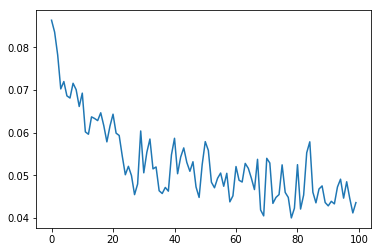

In [13]:
plt.plot(results_k.history['loss'])
plt.show()

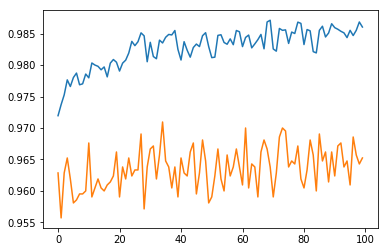

In [14]:
plt.plot(results_k.history['acc'])
plt.plot(results_k.history['val_acc'])
plt.show()

In [20]:
model.save('keras.h5')

In [3]:
df_test = pd.read_csv('test.csv')
df_test /= 255
X_test = df_test.values
model2 = keras.models.load_model('keras.h5')
print('loaded')
y_predict = model2.predict(X_test)
print('predicted')
y_predict = y_predict.argmax(axis=1)
df_predict = pd.DataFrame(y_predict)
df_predict.to_csv('output.csv', index=False, header=None)

loaded
predicted


In [24]:
y_predict.argmax(axis=1)

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [17]:
df_test = pd.read_csv('test.csv')
print(df_test.shape)



(28000, 784)


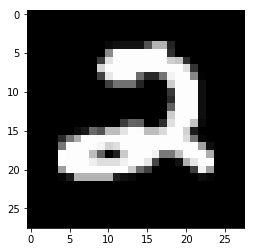

In [18]:
picture = df_test.iloc[0].values
# Reshape the array into 28 x 28 array (2-dimensional array)
pixels = picture.reshape((28, 28))

# Plot
#plt.title('Label is {label}'.format(label=label))
plt.imshow(pixels, cmap='gray')
plt.show()

In [19]:
picture

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  10,  17,  17,  17,  17,  81, 180, 180,
        35,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 139, 253, 253, 253, 253, 253,
       253, 253,  48,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  60, 228, 253, 25

In [6]:
print(X_train_my.shape)
print(Y_train_my.shape)
print(X_dev_my.shape)
print(Y_dev_my.shape)

(784, 39900)
(10, 39900)
(784, 2100)
(10, 2100)


In [20]:
type(X_train[0][0])

numpy.float64

In [61]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\DeepLearning\\DNN.py'>

In [74]:
#random seed for parameters init and mini batch shuffle
np.random.seed(0) 
dnn = DNN.DNN()
dnn.add_input_layer(X_train_my.shape[0])
dnn.add_layer(200, DNN.relu)
dnn.add_layer(50, DNN.relu)
dnn.add_layer(10, DNN.softmax)
dnn.costfunction = DNN.categorical_crossentropy
dnn.init = 'He'
#dnn.init = 'Lecun'
#dnn.optimizer = ('GD', 0.9)
dnn.optimizer = 'Adam'
#dnn.lambd = 0.5
dnn.compile()

results_my = {'loss': [], 'eval0': [], 'eval1': []}

In [81]:
learning_rate = 0.01
epochs = 100
batch_size = 256
verbose = 10
gradient_check=False
num_parameters = 2500

dnn.lambd = 0.1

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results_tmp = dnn.fit(X_train_my, Y_train_my, eval_set=eval_set, eval_metric='error', learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, verbose=verbose)

Y_predict_my = dnn.predict(X_train_my)
accuracy = accuracy_score(Y_predict_my.argmax(axis=0), Y_train_my.argmax(axis=0))
print('Accuracy train', accuracy)
Y_predict_my = dnn.predict(X_dev_my)
accuracy = accuracy_score(Y_predict_my.argmax(axis=0), Y_dev_my.argmax(axis=0))
print('Accuracy dev', accuracy)

if 'results_my' not in locals():
    results_my = {'loss': [], 'eval0': [], 'eval1': []}
    
results_my['loss'] += results_tmp['loss']
results_my['eval0'] += results_tmp['eval0']
results_my['eval1'] += results_tmp['eval1']


2017-10-10 10:42:45.867425 Cost after iteration 0 ['24.040491', '0.957694', '0.941429']
2017-10-10 10:43:18.380271 Cost after iteration 10 ['0.247894', '0.978145', '0.963810']
2017-10-10 10:43:50.880883 Cost after iteration 20 ['0.192956', '0.977494', '0.960476']
2017-10-10 10:44:24.409468 Cost after iteration 30 ['0.173185', '0.969023', '0.955238']
2017-10-10 10:44:58.939958 Cost after iteration 40 ['0.169913', '0.977168', '0.965714']
2017-10-10 10:45:33.140261 Cost after iteration 50 ['0.166455', '0.976717', '0.963810']
2017-10-10 10:46:05.734715 Cost after iteration 60 ['0.165814', '0.980852', '0.966667']
2017-10-10 10:46:39.255781 Cost after iteration 70 ['0.165836', '0.981805', '0.966667']
2017-10-10 10:47:11.596295 Cost after iteration 80 ['0.159778', '0.976842', '0.962857']
2017-10-10 10:48:09.666274 Cost after iteration 90 ['0.156227', '0.976090', '0.960000']
Accuracy train 0.976892230576
Accuracy dev 0.961904761905


In [ ]:
parameters = ([200, 50], 'relu', 100, 0.1, 256, 'GD', 0.9)
Accuracy train 1.0
Accuracy dev 0.972857142857

parameters = ([200, 50], 'relu', 100, 0.01, 256, 'Adam')
Accuracy train 0.994937343358
Accuracy dev 0.970952380952
+500
Accuracy train 0.999749373434
Accuracy dev 0.976666666667

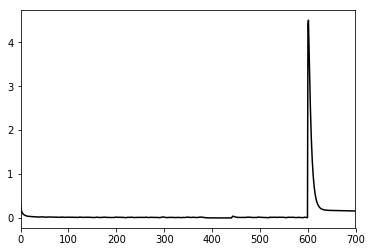

In [82]:
#plt.plot(results_my['loss'])
#plt.show()
df_loss = pd.DataFrame(results_my['loss'][0:])
df_loss[0].ewm(span=10).mean().plot(style='k')

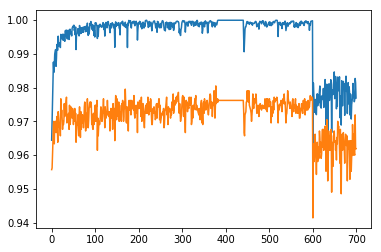

"\ndf_eval0 = pd.DataFrame(results_my['eval0'][0:])\ndf_eval0[0].ewm(span=10).mean().plot(style='k')\ndf_eval1 = pd.DataFrame(results_my['eval1'][0:])\ndf_eval1[0].ewm(span=10).mean().plot(style='k')\n"

In [83]:
plt.plot(results_my['eval0'])
plt.plot(results_my['eval1'])
plt.show()
'''
df_eval0 = pd.DataFrame(results_my['eval0'][0:])
df_eval0[0].ewm(span=10).mean().plot(style='k')
df_eval1 = pd.DataFrame(results_my['eval1'][0:])
df_eval1[0].ewm(span=10).mean().plot(style='k')
'''

3.4727090510081964